# OPT -> Etape de modélisation : 

Le but de cette étape est d'utiliser un algorithme de machine learning qui va essayer de prédire les tendences du marché en se basant sur les données historiques . 

Cette étape de modélisation vient aprés une étape de collecte de données via l'API bianance. Pour récupérer ces données collectés on va établir une liaison avec la base de données préalablement dockerisée . 


In [1]:
#to know which environment we are working in 
import sys
print(sys.executable)


/home/ubuntu/BinBot/binbotvenv/bin/python3


In [2]:
import mysql.connector

import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import statsmodels.tsa.api as tsa
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
from pandas.plotting import register_matplotlib_converters
from scipy.stats import boxcox
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
import statsmodels.api as sm


from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime, timedelta
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV



%matplotlib inline

## Connexion avec la base  de données Mysql : 


In [3]:
cnx = mysql.connector.connect(user='root', password='temp123',
                              host=' 0.0.0.0', port='3306',
                              database='opa')
## remplacer host par l'ID de votre machine virtuelle 
## port : représente le port ou elle est logée notre DB sur le docker 
cursor = cnx.cursor()

# Execute a query to retrieve data from a table
query = "SELECT * FROM historical_klines"
cursor.execute(query)

# Load the data into a Pandas DataFrame
data = pd.DataFrame(cursor.fetchall(), columns=['id_symint', 'open_time', 'open_price', 'high_price', 'low_price',
       'close_price', 'volume', 'close_time', 'quote_asset_volume',
       'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume'])
display(data.head())

cursor.close()
cnx.close()

,id_symint,open_time,open_price,high_price,low_price,close_price,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,1,1502942400000,4261.48,4313.62,4261.32,4308.83,47.181000,1502945999999,202366.0,171.0,35.160500,150952.00
1,1,1502946000000,4308.83,4328.69,4291.37,4315.32,23.234900,1502949599999,100305.0,102.0,21.448100,92608.30
2,1,1502949600000,4330.29,4345.45,4309.37,4324.35,7.229690,1502953199999,31282.3,36.0,4.802860,20795.30
3,1,1502953200000,4316.62,4349.99,4287.41,4349.99,4.443250,1502956799999,19241.1,25.0,2.602290,11291.30
4,1,1502956800000,4333.32,4377.85,4333.32,4360.69,0.972807,1502960399999,4239.5,28.0,0.814655,3552.75


In [4]:
data['close_time'] = pd.to_datetime(data['close_time'], unit='ms')
data = data.set_index('close_time')
data.sort_index(inplace = True)
data.columns

Index(['id_symint', 'open_time', 'open_price', 'high_price', 'low_price',
       'close_price', 'volume', 'quote_asset_volume', 'number_of_trades',
       'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume'],
      dtype='object')

## Modélisation : 

Pour l'étape de modélisation on a testé trois approches : 
* Un modéle de régression : avec les forêts aléatoires(Random Forest Regressor) avec comme variable target close price 
* Un modèle de classification : avec les forêts aléatoires( Random Forest Classifier) avec comme variable target 'is_profit qui prend True si l’action a atteint l’objectif de profit de 1% , False dans le cas contraire. 
* Les séries temporelles : on a testé les modèles d'ARIMA , ARIMAX 

### 1. Random Forest Regressor : 

In [5]:
#fill any missing values
data = data.ffill()
# Drop any rows with missing values
data.dropna(inplace=True)

#Ce code crée six colonnes décalées pour chacune des colonnes spécifiées dans lag_columns. La variable lag_count détermine le nombre de colonnes décalées à créer. La boucle for imbriquée parcourt chaque colonne et crée les colonnes décalées en utilisant la méthode shift(). Enfin, la fonction dropna() supprime les lignes avec des valeurs manquantes résultant du décalage.

In [6]:
##Create lagged features for the Random Forest model for each column 

lag_columns = ['open_price', 'high_price', 'low_price', 'close_price', 'volume', 
               'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 
               'taker_buy_quote_asset_volume']

lag_count = 6

for col in lag_columns:
    for lag in range(1, lag_count + 1):
        data[f'{col}_lag{lag}'] = data[col].shift(lag)

# Supprimer les lignes avec des valeurs manquantes après la création des colonnes décalées
data.dropna(inplace=True)


In [7]:
# Récupérer les noms de colonnes
column_names = data.columns

# Afficher les noms de colonnes avec une numérotation
for idx, col_name in enumerate(column_names, 1):
    print(f"{idx}. {col_name}")

1. id_symint
2. open_time
3. open_price
4. high_price
5. low_price
6. close_price
7. volume
8. quote_asset_volume
9. number_of_trades
10. taker_buy_base_asset_volume
11. taker_buy_quote_asset_volume
12. open_price_lag1
13. open_price_lag2
14. open_price_lag3
15. open_price_lag4
16. open_price_lag5
17. open_price_lag6
18. high_price_lag1
19. high_price_lag2
20. high_price_lag3
21. high_price_lag4
22. high_price_lag5
23. high_price_lag6
24. low_price_lag1
25. low_price_lag2
26. low_price_lag3
27. low_price_lag4
28. low_price_lag5
29. low_price_lag6
30. close_price_lag1
31. close_price_lag2
32. close_price_lag3
33. close_price_lag4
34. close_price_lag5
35. close_price_lag6
36. volume_lag1
37. volume_lag2
38. volume_lag3
39. volume_lag4
40. volume_lag5
41. volume_lag6
42. quote_asset_volume_lag1
43. quote_asset_volume_lag2
44. quote_asset_volume_lag3
45. quote_asset_volume_lag4
46. quote_asset_volume_lag5
47. quote_asset_volume_lag6
48. number_of_trades_lag1
49. number_of_trades_lag2
50. n

In [8]:
# Supprimer les colonnes indésirables pour les fonctionnalités
feats = data.drop(['close_price', 'id_symint', 'open_time'], axis=1)

# Utiliser la colonne 'close_price' comme cible
target = data['close_price']

# Pourcentage des données à utiliser pour l'ensemble de test (par exemple, 20%)
test_size = 0.2

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=test_size, random_state=42)

In [ ]:
# Définir les hyperparamètres à tester
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Créer une instance du modèle RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)

# Créer une instance de GridSearchCV pour rechercher les meilleurs hyperparamètres
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Effectuer la recherche des meilleurs hyperparamètres en utilisant la validation croisée
grid_search.fit(feats, target)

# Récupérer le meilleur modèle
best_model = grid_search.best_estimator_

print("Best model parameters: ", grid_search.best_params_)
print("Best model MSE: ", -grid_search.best_score_)


Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [9]:
# Predict the close price for the next hour
next_hour = data.index[-1] + timedelta(hours=1)
next_hour_data = pd.DataFrame({
    'open_price': [data.iloc[-1]['open_price']],
    'high_price': [data.iloc[-1]['high_price']],
    'low_price': [data.iloc[-1]['low_price']],
    'volume': [data.iloc[-1]['volume']],
    'quote_asset_volume': [data.iloc[-1]['quote_asset_volume']],
    'number_of_trades': [data.iloc[-1]['number_of_trades']],
    'taker_buy_base_asset_volume': [data.iloc[-1]['taker_buy_base_asset_volume']],
    'taker_buy_quote_asset_volume': [data.iloc[-1]['taker_buy_quote_asset_volume']],
    'close_price_lag1': [data.iloc[-1]['close_price']],
    'close_price_lag2': [data.iloc[-2]['close_price']],
    'close_price_lag3': [data.iloc[-3]['close_price']],
    'close_price_lag4': [data.iloc[-4]['close_price']]
})

next_hour_close_price = model.predict(next_hour_data)[0]

# # Convert the timezone of the next_hour index to local timezone
# local_tz = pytz.timezone('Europe/Paris')
# next_hour = next_hour.astimezone(local_tz)

# Print the predicted close price for the next hour
print(f"Predicted close price for {next_hour}: {next_hour_close_price:.2f}")

# Plot the actual and predicted close prices for the last 24 hours
last_24_hours = data.iloc[-24:]
actual_close_prices = last_24_hours['close_price']
print("########################## actual_close_prices ##########################\n")
print(actual_close_prices)

predicted_close_prices = pd.Series(model.predict(feats[-24:]), index=last_24_hours.index)
print("########################## predicted_close_prices ##########################\n")
print(predicted_close_prices)




Predicted close price for 2023-03-06 20:59:59.999000: 22416.85
########################## actual_close_prices ##########################

close_time
2023-03-05 20:59:59.999    22409.1
2023-03-05 21:59:59.999    22483.5
2023-03-05 22:59:59.999    22433.0
2023-03-05 23:59:59.999    22430.2
2023-03-06 00:59:59.999    22446.5
2023-03-06 01:59:59.999    22379.2
2023-03-06 02:59:59.999    22391.6
2023-03-06 03:59:59.999    22387.2
2023-03-06 04:59:59.999    22342.6
2023-03-06 05:59:59.999    22370.2
2023-03-06 06:59:59.999    22405.9
2023-03-06 07:59:59.999    22392.7
2023-03-06 08:59:59.999    22413.2
2023-03-06 09:59:59.999    22403.7
2023-03-06 10:59:59.999    22399.8
2023-03-06 11:59:59.999    22379.6
2023-03-06 12:59:59.999    22397.4
2023-03-06 13:59:59.999    22439.8
2023-03-06 14:59:59.999    22450.0
2023-03-06 15:59:59.999    22553.4
2023-03-06 16:59:59.999    22524.5
2023-03-06 17:59:59.999    22481.6
2023-03-06 18:59:59.999    22504.1
2023-03-06 19:59:59.999    22385.2
Name: close

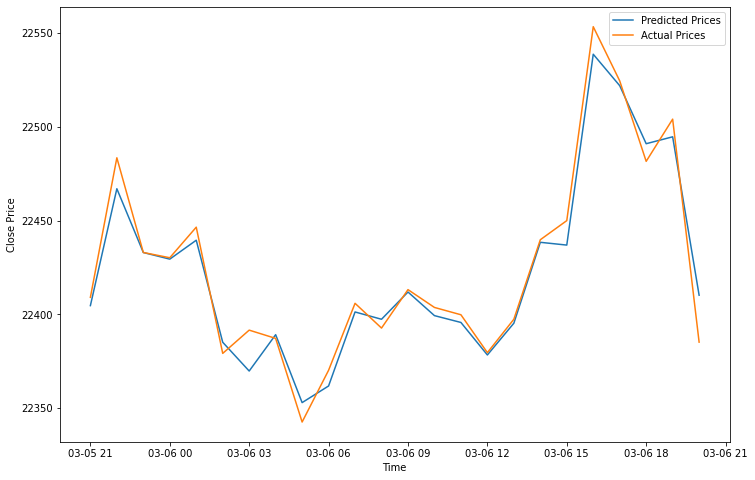

In [24]:
df_actual_prices = pd.DataFrame(actual_close_prices)
df_predicted_prices = pd.DataFrame(predicted_close_prices)
df_predicted_prices.rename(columns={0:"predicted_close_prices"}, inplace=True)
plt.figure(figsize=(12,8))

plt.plot(df_predicted_prices , label='Predicted Prices')
plt.plot(df_actual_prices , label='Actual Prices')


plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()


plt.show()

### 2. Random Forest Classifier  : 

In [57]:
df = data[['open_price', 'high_price', 'low_price','close_price', 'volume']]

In [58]:
df= df.rename(columns={'open_price':'open',
                          'high_price':'high',
                          'low_price':'low',
                           'close_price':'close',
                           'volume':'volume'
                          })

In [59]:
df.head(2)

,open,high,low,close,volume
close_time,,,,,
2017-08-17 12:59:59.999,4436.06,4449.56,4411.0,4411.0,23.0324
2017-08-17 13:59:59.999,4411.00,4459.00,4411.0,4459.0,31.3124


In [60]:

df['is_profit'] = ((df['close'] - df['open']) / df['open']) >= 0.01

def get_rsi(df, rsi_period):
    chg = df['close'].diff(1)
    gain = chg.mask(chg<0,0)
    loss = chg.mask(chg>0,0)
    avg_gain = gain.ewm(com=rsi_period-1, min_periods=rsi_period).mean()
    avg_loss = loss.ewm(com=rsi_period-1, min_periods=rsi_period).mean()
    rs = abs(avg_gain/avg_loss)
    rsi = 100 - (100/(1+rs))
    return rsi

# relative strength index
df['rsi14'] = get_rsi(df, 14)


# moving averages
df['sma9'] = df['close'].rolling(9).mean()
df['sma180'] = df['close'].rolling(180).mean()
df['sma9_var'] = (df['close']/df['sma9'])-1
df['sma180_var'] = (df['close']/df['sma180'])-1

# spreads
df['spread']=((df['close']/df['open'])-1).abs()
df['spread14_e']=df['spread'].ewm(span=14).mean()

# volume-based indicator
df['volume14'] = df['volume'].rolling(14).mean()
df['volume34'] = df['volume'].rolling(34).mean()
df['volume14_34_var'] = (df['volume14']/df['volume34'])-1



In [61]:
df.dropna(inplace=True)

In [62]:
df.head(2)

,open,high,low,close,volume,is_profit,rsi14,sma9,sma180,sma9_var,sma180_var,spread,spread14_e,volume14,volume34,volume14_34_var
close_time,,,,,,,,,,,,,,,,
2017-08-24 23:59:59.999,4326.24,4371.68,4297.76,4316.01,35.7757,False,67.348846,4233.887778,4108.895389,0.019396,0.050406,0.002365,0.007427,33.537679,35.533721,-0.056173
2017-08-25 00:59:59.999,4316.01,4369.00,4310.59,4366.00,48.1898,True,71.318581,4249.887778,4108.645389,0.027321,0.062637,0.011582,0.007981,32.230193,35.235953,-0.085304


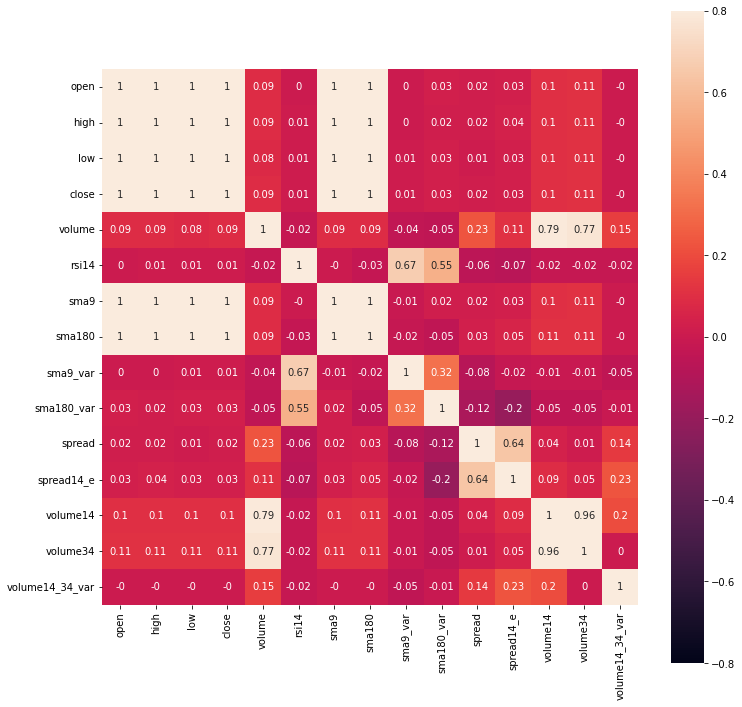

In [66]:
df_corr = df.drop(columns=['is_profit']).corr().round(2)
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(df_corr, vmin=-.8, vmax=.8, square=1 , annot=True)

In [69]:

train, test = train_test_split(df, test_size=0.2, random_state=42)

# Separate the label
y = train['is_profit'].copy()
X = train.drop(columns=['is_profit'])
y_test = test['is_profit'].copy()
X_test = test.drop(columns=['is_profit'])

In [70]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler

float_cols = df.select_dtypes(include='float64').columns
tf = ColumnTransformer(
    [('RobustScaler', RobustScaler(), float_cols)],
    remainder='passthrough',
)
tf.fit(X)
X = tf.transform(X)
X_test = tf.transform(X_test)

roc_auc_score: 0.9950323923172587


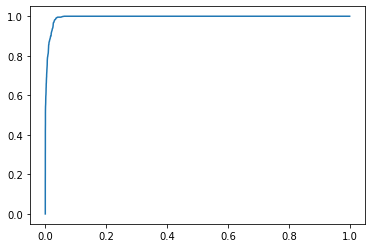

In [76]:


model = RandomForestClassifier()
model.fit(X, y)

# Evaluate model on test data
y_test_pp = model.predict_proba(X_test)
print('roc_auc_score:', roc_auc_score(y_test, y_test_pp[:,1]))
fpr, tpr, thres = roc_curve(y_test, y_test_pp[:,1])
ax = plt.plot(fpr, tpr)
plt.show()

In [81]:
random_grid = {
    'n_estimators': [400,800],
    'max_depth': [2048, None],
    'max_features': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 4],
}
model = RandomForestClassifier()
random_cv = RandomizedSearchCV(
    estimator = model,
    param_distributions = random_grid,
    n_iter = 8,
    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
    verbose=2,
    random_state=42,
    n_jobs = -1,
    scoring = 'roc_auc'
)
random_cv.fit(X, y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(), n_iter=8, n_jobs=-1,
                   param_distributions={'max_depth': [2048, None],
                                        'max_features': [2, 3, 4, 5],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 4],
                                        'n_estimators': [400, 800]},
                   random_state=42, scoring='roc_auc', verbose=2)

roc_auc_score: 0.9953690490037885


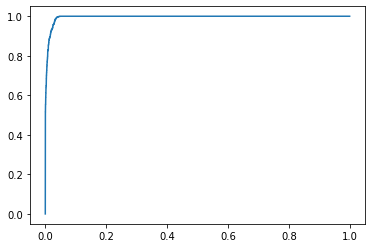

In [82]:
# Fit model
params = {
    'max_depth': 2048,
    'max_features': 3,
    'min_samples_leaf': 2,
    'min_samples_split': 2,
    'n_estimators': 800,
}
model = RandomForestClassifier(**params)
model.fit(X, y)

# Evaluate
y_test_pp = model.predict_proba(X_test)
print('roc_auc_score:', roc_auc_score(y_test, y_test_pp[:,1]))
fpr, tpr, thres = roc_curve(y_test, y_test_pp[:,1])
ax = plt.plot(fpr, tpr)
plt.show()

In [93]:
importances = model.feature_importances_
features = train.drop(columns='is_profit').columns
feat_importances = pd.DataFrame({'feature': features, 'importance': importances})


feat_importances = pd.DataFrame(feat_importances.sort_values('importance', ascending=False).reset_index(drop=True))


display(feat_importances)

,feature,importance
0,spread,0.445297
1,sma9_var,0.219455
2,rsi14,0.069176
3,spread14_e,0.066452
4,volume,0.031916
5,sma180_var,0.026030
6,volume14,0.020385
7,volume14_34_var,0.019896
8,volume34,0.019274
9,open,0.016351


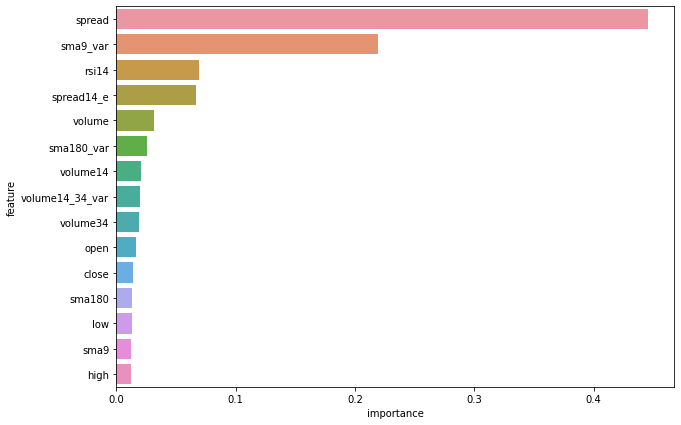

In [97]:
plt.figure(figsize=(10,7))
sns.barplot(x=feat_importances.importance, y = feat_importances.feature)
plt.show()

### 3. Séries temporelles   : 

In [101]:
hourly = df.drop(columns='is_profit')
hourly['log_open'] = np.log(hourly['open'])
hourly['log_close'] = np.log(hourly['close'])

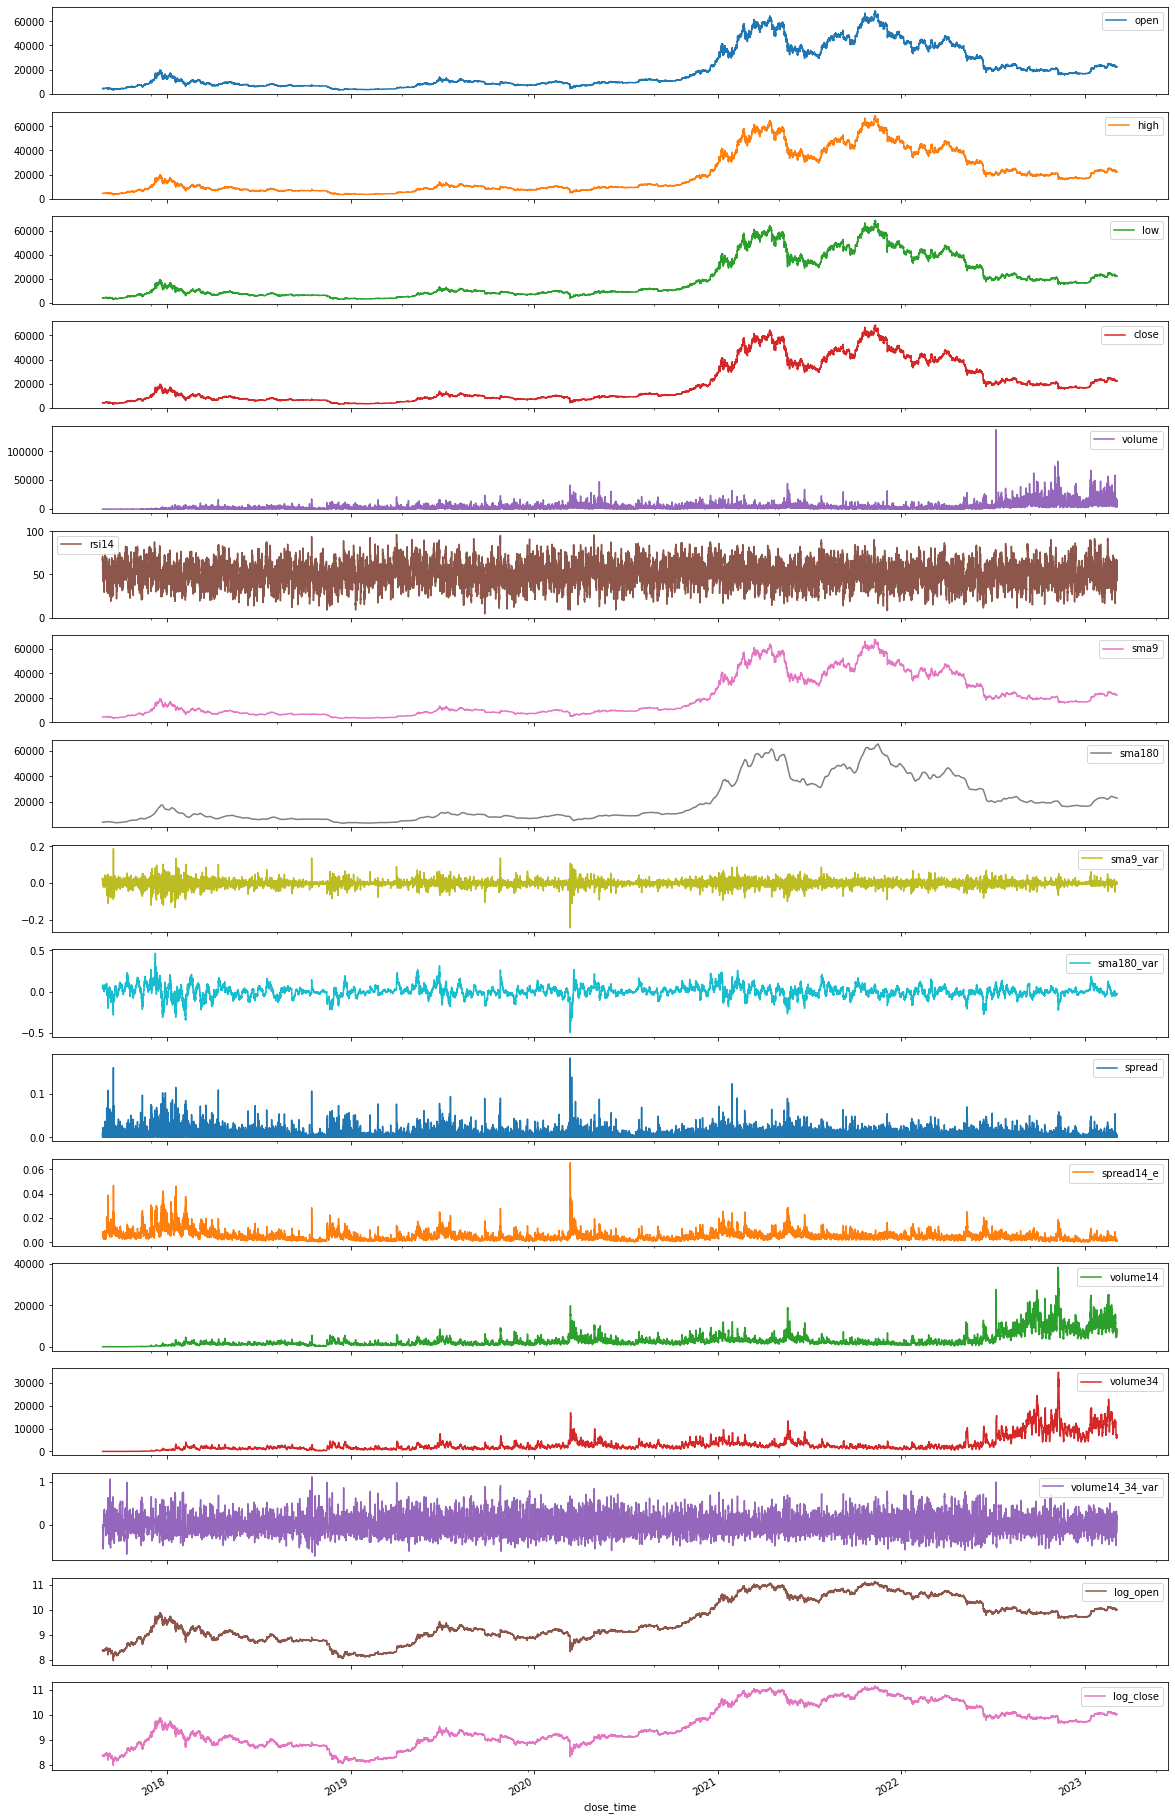

In [102]:
hourly.plot(figsize=(20,36), subplots=True, legend=True);

Dickey-Fuller Log Closing Price score: -1.4852676975340842
Dickey-Fuller Log Closing Price p-value: 0.5407862031300287


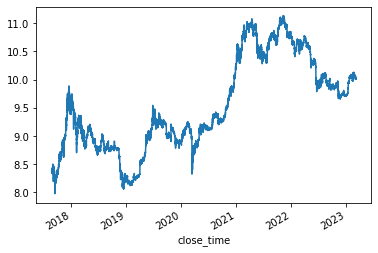

In [103]:
adf_log_close = adfuller(hourly['log_close'])
print(f'Dickey-Fuller Log Closing Price score: {adf_log_close[0]}')
print(f'Dickey-Fuller Log Closing Price p-value: {adf_log_close[1]}')
hourly['log_close'].plot();

###### -> La série temporelle n'est pas stationnaire cela se confirme visualement et avec la valeur de p-value > 5%

Dickey-Fuller Log Closing Price Differenced p-value: -30.5669334630999
Dickey-Fuller Log Closing Price Differenced p-value: 0.0


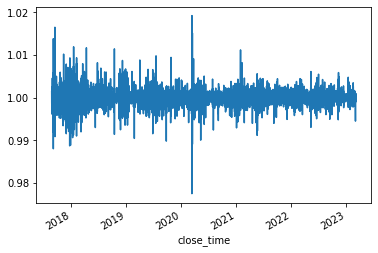

In [104]:
hourly['log_close_diff'] = (hourly['log_close']/hourly['log_close'].shift(1))
adf_log_close_diff = adfuller(hourly['log_close_diff'].dropna())
print(f'Dickey-Fuller Log Closing Price Differenced p-value: {adf_log_close_diff[0]}')
print(f'Dickey-Fuller Log Closing Price Differenced p-value: {adf_log_close_diff[1]}')
hourly['log_close_diff'].plot();

######  Modélisation avec ARIMA : 

In [105]:
def ARIMA_model(df):
    
    y = df['log_close']

    aic_scores = []

    train_size = [len(y),500,250,100,50]

    for p in range(3):
        for d in range(1,4):
            for q in range(3):
                for size in train_size:
                    model = ARIMA(endog = y.tail(size), order =(p,d,q))
                    fitmodel = model.fit()
                    rmse = np.sqrt(fitmodel.mse)
                    aic_scores.append(pd.DataFrame(['ARIMA', size, (p,d,q), fitmodel.aic, rmse]).T)
                    
    arima_df = pd.concat(aic_scores, axis = 0)
    arima_df.set_axis(['model type', 'train_size', 'order', 'AIC', 'RMSE'], axis = 1, inplace = True)
    return_df = arima_df.sort_values(['train_size','RMSE'], ascending = [False,True]).reset_index(drop = True)
    
    return return_df

In [107]:
arima = ARIMA_model(hourly)

######  Modélisation avec ARIMAX : 

In [111]:
def ARIMAX_model(df, test_size = 3):
    
    df = df.drop(['close', 'log_close_diff'], axis =1)
    
    x = df.drop('log_close', axis = 1)
    y = df['log_close']

    aic_scores = []

    train_size = [len(y),500,250,100,50]

    for p in range(3):
        for d in range(1,4):
            for q in range(3):
                for size in train_size:
                    model = ARIMA(endog = y.tail(size), exog = x.tail(size), order =(p,d,q))
                    fitmodel = model.fit()
                    rmse = np.sqrt(fitmodel.mse)
                    aic_scores.append(pd.DataFrame(['ARIMAX', size, (p,d,q), fitmodel.aic, rmse]).T)
                    
    arimax_df = pd.concat(aic_scores, axis = 0)
    arimax_df.set_axis(['model type','train_size', 'order', 'AIC', 'RMSE'], axis = 1, inplace = True)
    return_df = arimax_df.sort_values(['train_size','RMSE'], ascending = [False,True]).reset_index(drop = True)
    
    return return_df

In [112]:
arimax = ARIMAX_model(hourly)


In [114]:
models = pd.concat([arima, arimax], axis = 0)
models = models.sort_values(['train_size','RMSE'], ascending = [False,True])
models.head(3)

,model type,train_size,order,AIC,RMSE
0,ARIMAX,48350,"(1, 1, 2)",-533691.648351,0.036332
1,ARIMAX,48350,"(2, 1, 2)",-533687.389029,0.036332
2,ARIMAX,48350,"(2, 1, 1)",-533106.129272,0.036332


In [115]:
best_model = ARIMA(endog = hourly['log_close'], order =(1,1,2))
best_model_fit = best_model.fit()
print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              log_close   No. Observations:                48350
Model:                 ARIMA(1, 1, 2)   Log Likelihood              159450.850
Date:                Mon, 13 Mar 2023   AIC                        -318893.701
Time:                        23:39:30   BIC                        -318858.556
Sample:                             0   HQIC                       -318882.674
                              - 48350                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2361      0.050      4.693      0.000       0.137       0.335
ma.L1         -0.2838      0.050     -5.681      0.000      -0.382      -0.186
ma.L2         -0.0216      0.003     -6.496      0.0

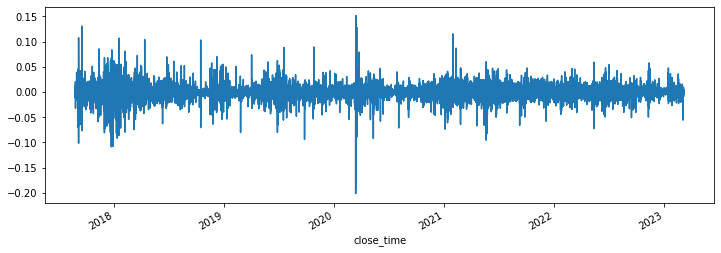

In [116]:
best_model_fit.resid[1:].plot(figsize = (12,4));

In [118]:
hourly.index = hourly.index.strftime('%Y-%m-%d %H:%M:%S')
print(hourly.index.max())

2023-03-06 19:59:59


###### Forcasting: 

In [125]:

def predictions(df, start_date='2023-03-06', forecast_horizon=48):

    date = datetime.strptime(start_date, '%Y-%m-%d')

    d = pd.date_range(start=date, end=date + timedelta(hours=forecast_horizon-1), freq='H')

    data = hourly.tail(168)['log_close']
    data.index = pd.DatetimeIndex(data.index)

    predictions = []
    for date in d:
        y = data[data.index < date]
        model = ARIMA(endog=y, order=(2,1,2))
        fitmodel = model.fit()
        y_pred = fitmodel.forecast()
        
        predictions.append([date, np.exp(y_pred.values[0])])
    preds = pd.DataFrame(predictions, columns=['close_time', 'pred_today']).set_index('close_time')
    return preds 
    
    


predictions = predictions(hourly, start_date='2023-03-06', forecast_horizon=24)
predictions

,pred_today
close_time,
2023-03-06 00:00:00,22428.811604
2023-03-06 01:00:00,22446.519928
2023-03-06 02:00:00,22386.933493
2023-03-06 03:00:00,22390.465856
2023-03-06 04:00:00,22389.084691
2023-03-06 05:00:00,22347.764702
2023-03-06 06:00:00,22367.189250
2023-03-06 07:00:00,22401.714226
2023-03-06 08:00:00,22393.592704


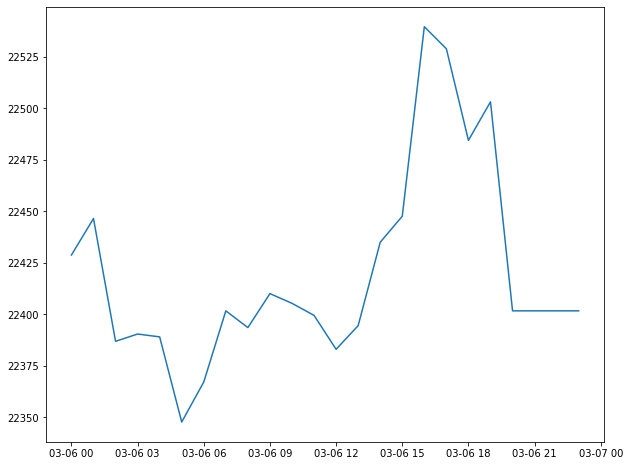

In [145]:
plt.figure(figsize=(10,8))
real_df =pd.DataFrame(hourly.tail(20)['close'])
plt.plot(predictions)
plt.show()